# ABC Pharmaceuticals

ABC Pharmaceuticals is embarking on a process to model the inputs and potential revenue generated from our three products given different views on the demand and costs of producing these. This code is for internal analysis of the data coming from our production facility to determine if we can build a model that will allow us to have a clear view of the feed requirements for different forward looking scenarios.

### Required Imports

In [49]:
import pandas as pd
import numpy as np
import joblib
import nbformat
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'colab'
from scipy.optimize import differential_evolution
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Data Exploration

ABC Chemicals produces three primary products. To do this, they use 4 raw feed inputs into three operational units. The feed inputs are liquids and have units of measure of mega-litres (Ml), while the three primary products are measured in kilograms (kg). Each feed input is processed through a unit. Due to the type of process occurring, it is possible to also produce by-products. The past 4 years worth of data is in the excel document (Data Inputs.xlsx)

In [50]:
input_data = pd.read_excel("Data_Inputs.xlsx")
input_data.head()

Timestamp        Raw1  ByProduct   Product1  ByProduct_From_1_to_2  \
0 2019-07-01  150.006321  44.050057  11.867058               9.189283   
1 2019-07-02  150.039418  44.941743  10.580847               0.000000   
2 2019-07-03  149.979928  46.127335  11.531425               8.978365   
3 2019-07-04  149.997513  45.799040  11.222656               8.768551   
4 2019-07-05  149.996951  45.450219  13.431639               8.637838   

       Raw2  Product2  ByProduct_From_1_to_3    Raw3_1    Raw3_2  Product3  
0  2.006054  3.580789               0.241373  5.311984  0.649544  2.313002  
1  0.000000  0.000000               0.000000  4.976112  0.649954  2.219060  
2  2.599721  3.707705               0.000000  4.716594  0.616795  2.173808  
3  2.581957  3.645370               0.000000  4.674946  0.600060  2.123399  
4  2.609625  3.689441               0.000000  4.799645  0.600083  2.136561

As a first analysis, let us explore the data to ensure that it is complete and usable

In [51]:
#Count same number of entries for all
print(f"Counting rows per feature:", input_data.count())

#Check for nulls 
print(f"Counting number of nulls per feature:", input_data.where(input_data.isna()).count())

# #Check for correct datatypes 
print(f"DataType check:",input_data.dtypes)

Counting rows per feature: Timestamp                1763
Raw1                     1763
ByProduct                1763
Product1                 1763
ByProduct_From_1_to_2    1763
Raw2                     1763
Product2                 1763
ByProduct_From_1_to_3    1763
Raw3_1                   1763
Raw3_2                   1763
Product3                 1763
dtype: int64
Counting number of nulls per feature: Timestamp                0
Raw1                     0
ByProduct                0
Product1                 0
ByProduct_From_1_to_2    0
Raw2                     0
Product2                 0
ByProduct_From_1_to_3    0
Raw3_1                   0
Raw3_2                   0
Product3                 0
dtype: int64
DataType check: Timestamp                datetime64[ns]
Raw1                            float64
ByProduct                       float64
Product1                        float64
ByProduct_From_1_to_2           float64
Raw2                            float64
Product2                  

In [52]:
print("Available columns:", input_data.columns.tolist())

Available columns: ['Timestamp', 'Raw1', 'ByProduct', 'Product1', 'ByProduct_From_1_to_2', 'Raw2', 'Product2', 'ByProduct_From_1_to_3', 'Raw3_1', 'Raw3_2', 'Product3']


Let us continue and plot out the inputs and outputs from the data frame as time series plots

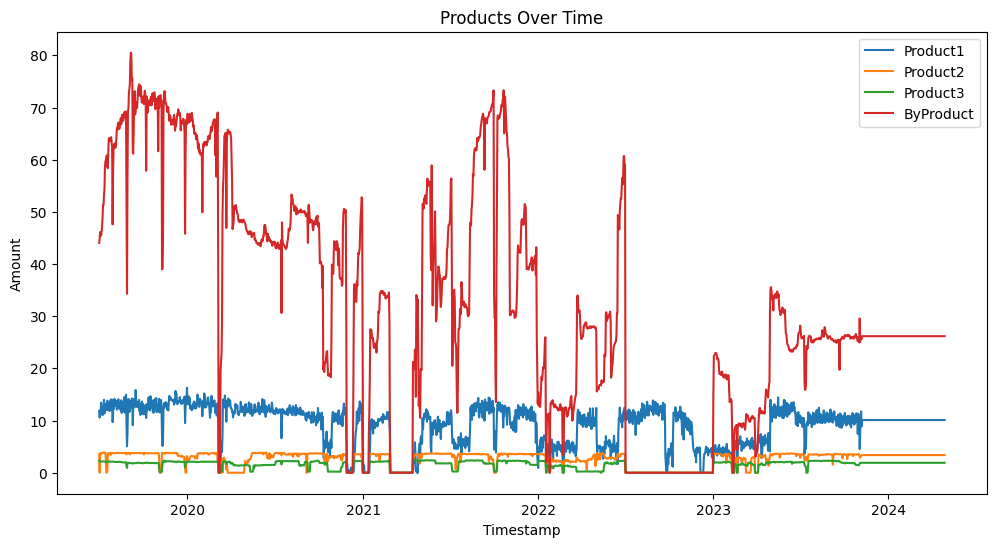

/Users/willmadikizela/Library/Python/3.9/lib/python/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



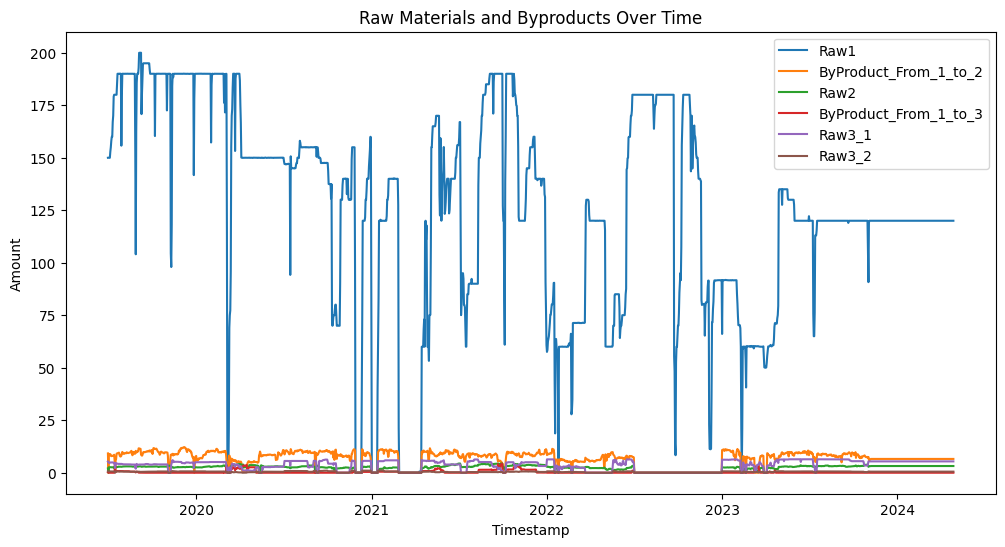

In [53]:
# Convert timestamp
input_data["Timestamp"] = pd.to_datetime(input_data["Timestamp"])

# First plot group - Products
# Using matplotlib
plt.figure(figsize=(12, 6))
for title in ["Product1", "Product2", "Product3", "ByProduct"]:  # Changed ByProduct to Byproduct
    plt.plot(input_data["Timestamp"], input_data[title], label=title)
plt.legend()
plt.title("Products Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Amount")
plt.show()

# Using plotly
fig = go.Figure()
for title in ["Product1", "Product2", "Product3", "ByProduct"]:  # Changed ByProduct to Byproduct
    fig.add_trace(
        go.Scatter(
            mode='lines',
            x=input_data["Timestamp"],
            y=input_data[title],
            hoverinfo='skip',
            name=title
        )
    )
fig.update_layout(
    title="Products Over Time",
    xaxis_title="Timestamp",
    yaxis_title="Amount"
)
fig.show()

# Second plot group - Raw Materials and Byproducts
# Using matplotlib
plt.figure(figsize=(12, 6))
for title in ["Raw1", "ByProduct_From_1_to_2", "Raw2", "ByProduct_From_1_to_3", "Raw3_1", "Raw3_2"]:  # Changed ByProduct to Byproduct
    plt.plot(input_data["Timestamp"], input_data[title], label=title)
plt.legend()
plt.title("Raw Materials and Byproducts Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Amount")
plt.show()

# Using plotly
fig = go.Figure()
for title in ["Raw1", "ByProduct_From_1_to_2", "Raw2", "ByProduct_From_1_to_3", "Raw3_1", "Raw3_2"]:  # Changed ByProduct to Byproduct
    fig.add_trace(
        go.Scatter(
            mode='lines',
            x=input_data["Timestamp"],
            y=input_data[title],
            hoverinfo='skip',
            name=title
        )
    )
fig.update_layout(
    title="Raw Materials and ByProduct Over Time",
    xaxis_title="Timestamp",
    yaxis_title="Amount"
)
fig.show()

Next, let's go through each of the unit operations and see how the input data corresponds to the output from the unit

In [73]:
# If needed, run these commands:
!pip install plotly
!pip install nbformat

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [76]:
import plotly.io as pio
pio.renderers.default = "notebook"
# First let's verify the data
print("Column names in dataset:", input_data.columns.tolist())
print("\nFirst few rows of relevant columns:")
print(input_data[["Raw1", "Product1", "ByProduct"]].head())  # Changed from ByProduct to Byproduct

# Now create the plot
fig = go.Figure()

# Add Product1 trace
fig.add_trace(
    go.Scatter(
        mode='markers',
        x=input_data["Raw1"],
        y=input_data["Product1"],
        hoverinfo='skip',
        name="Product1",
        marker=dict(size=8)  # Added marker size for better visibility
    )
)

# Add Byproduct trace
fig.add_trace(
    go.Scatter(
        mode='markers',
        x=input_data["Raw1"],
        y=input_data["ByProduct"],  # Changed from ByProduct to Byproduct
        hoverinfo='skip',
        name="Byproduct",
        marker=dict(size=8)  # Added marker size for better visibility
    )
)

# Update layout
fig.update_layout(
    title="Byproduct and Product1 from Unit 1 as a function of Feed Raw1",
    xaxis_title="Raw1 (Ml)",
    yaxis_title="Product1 (kg), Byproduct (Ml)",
    showlegend=True,
    template="plotly_white"  # Added template for better visibility
)

# Show the plot
fig.show()

Column names in dataset: ['Timestamp', 'Raw1', 'ByProduct', 'Product1', 'ByProduct_From_1_to_2', 'Raw2', 'Product2', 'ByProduct_From_1_to_3', 'Raw3_1', 'Raw3_2', 'Product3']

First few rows of relevant columns:
         Raw1   Product1  ByProduct
0  150.006321  11.867058  44.050057
1  150.039418  10.580847  44.941743
2  149.979928  11.531425  46.127335
3  149.997513  11.222656  45.799040
4  149.996951  13.431639  45.450219


Next, unit 2. Unit 2 receives 2 inputs and therefore we need to consider each of them to see what the relationship might be

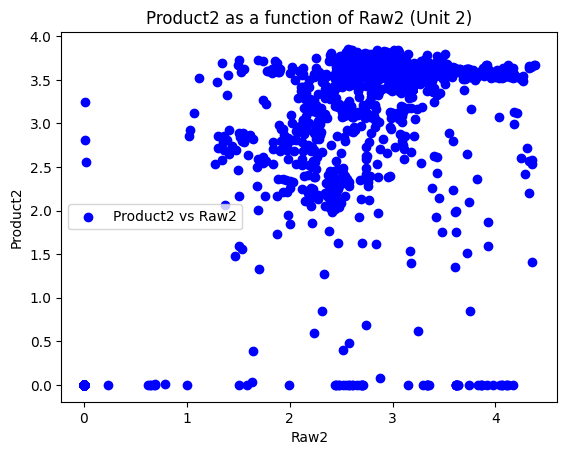

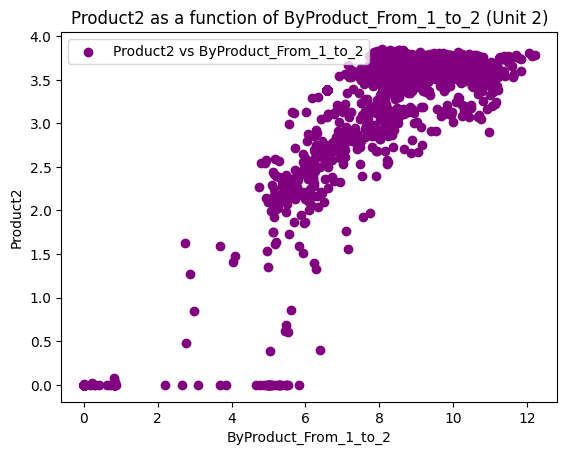

In [77]:
import matplotlib.pyplot as plt

# Unit 2

# Scatter plot for Raw2 vs Product2
plt.figure()
plt.scatter(input_data["Raw2"], input_data["Product2"], label="Product2 vs Raw2", color='blue')
plt.xlabel("Raw2")
plt.ylabel("Product2")
plt.title("Product2 as a function of Raw2 (Unit 2)")
plt.legend()
plt.show()

# Scatter plot for ByProduct_From_1_to_2 vs Product2
plt.figure()
plt.scatter(input_data["ByProduct_From_1_to_2"], input_data["Product2"], label="Product2 vs ByProduct_From_1_to_2", color='purple')
plt.xlabel("ByProduct_From_1_to_2")
plt.ylabel("Product2")
plt.title("Product2 as a function of ByProduct_From_1_to_2 (Unit 2)")
plt.legend()
plt.show()


And finally for unit3

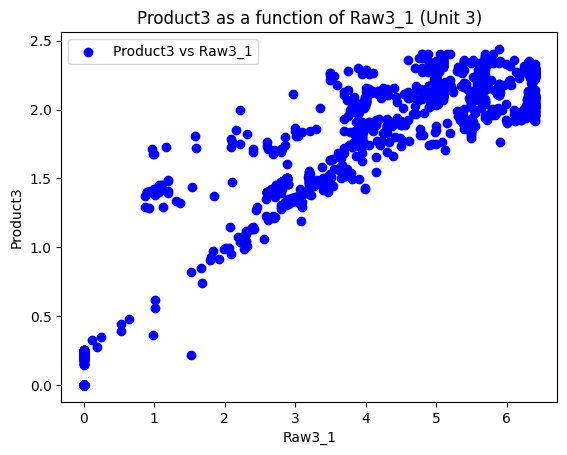

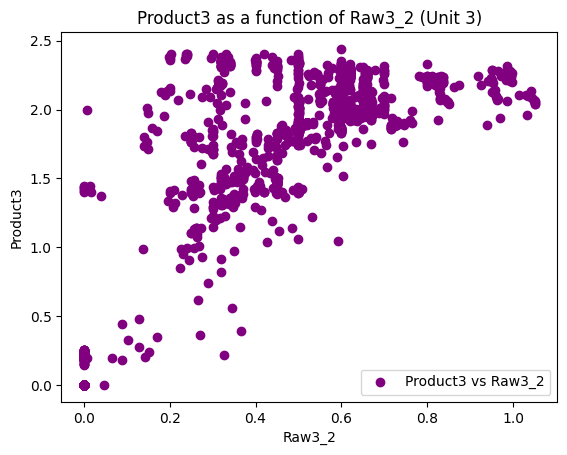

In [56]:
# TO DO: Replicate analysis above for unit 3
import matplotlib.pyplot as plt

# Unit 3

# Scatter plot for Raw3_1 vs Product3
plt.figure()
plt.scatter(input_data["Raw3_1"], input_data["Product3"], label="Product3 vs Raw3_1", color='blue')
plt.xlabel("Raw3_1")
plt.ylabel("Product3")
plt.title("Product3 as a function of Raw3_1 (Unit 3)")
plt.legend()
plt.show()

# Scatter plot for Raw3_2 vs Product3
plt.figure()
plt.scatter(input_data["Raw3_2"], input_data["Product3"], label="Product3 vs Raw3_2", color='purple')
plt.xlabel("Raw3_2")
plt.ylabel("Product3")
plt.title("Product3 as a function of Raw3_2 (Unit 3)")
plt.legend()
plt.show()


Just for completeness, let us do a correlation matrix as well

In [57]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


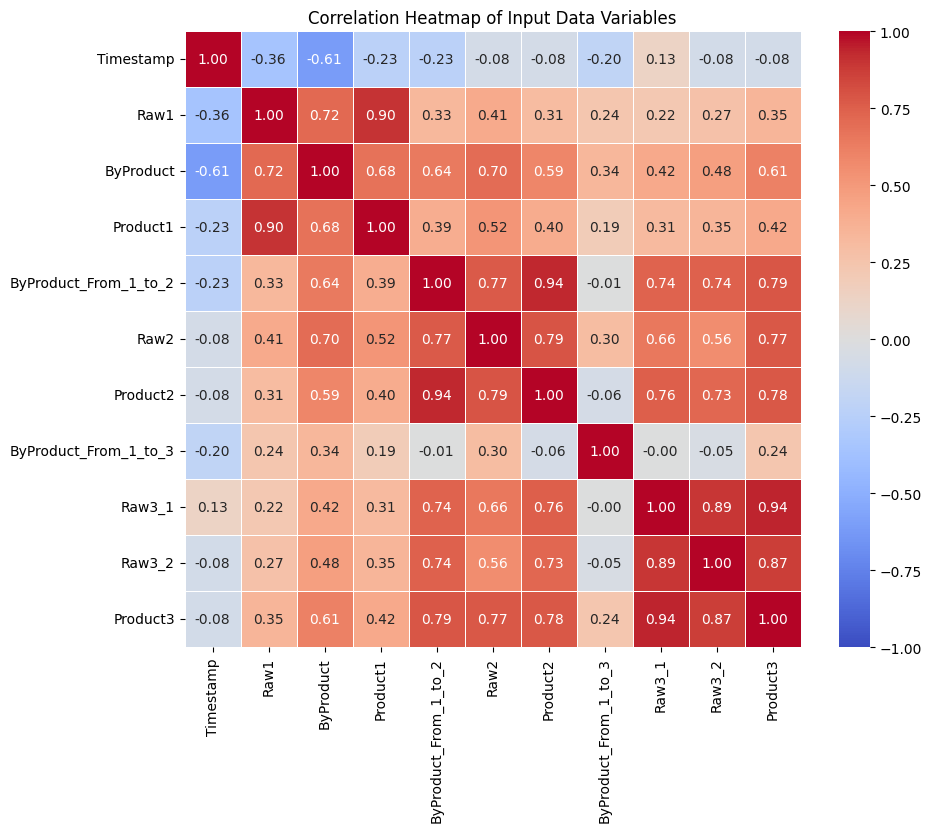

In [58]:
# TO DO: Plot a correlation heatmap
import seaborn as sns
# Calculate the correlation matrix
correlation_matrix = input_data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Plot the heatmap
sns.heatmap(
    correlation_matrix,
    annot=True,           # Display correlation values in cells
    cmap='coolwarm',      # Color scheme for better contrast
    vmin=-1, vmax=1,      # Limits for correlation values
    square=True,          # Keep cells square-shaped
    linewidths=0.5,       # Add lines between cells
    fmt=".2f"             # Format for the correlation values
)

# Set title for the heatmap
plt.title("Correlation Heatmap of Input Data Variables")
plt.show()


# Data Cleaning

Before we start cleaning the data, we will split the data into the inputs and outputs for each unit operation. We will also add the timestamp as the index.

In [59]:
unit_1 = input_data[["Raw1", "ByProduct", "Product1"]]
unit_1.index = input_data["Timestamp"]
unit_2 = input_data[["ByProduct_From_1_to_2", "Raw2", "Product2"]]
unit_2.index = input_data["Timestamp"]
unit_3 = input_data[["ByProduct_From_1_to_3", "Raw3_1", "Raw3_2", "Product3"]]
unit_3.index = input_data["Timestamp"]

#Checking output
unit_1.describe()

Raw1    ByProduct     Product1
count  1763.000000  1763.000000  1763.000000
mean    126.442377    32.454380     9.225475
std      49.583409    21.982259     3.768877
min       0.000000     0.000000     0.000000
25%      91.690002    17.179176     6.289587
50%     122.508976    26.589045    10.099381
75%     165.001311    48.386907    11.915804
max     200.026556    80.508544    16.266647

We need to clean the data before testing any models. An external source has provided code that can be used to do this. The function is is the helper_code file, and is called mahalanobis_outlier_removal. We have not yet had time to implement this approach.

In [60]:
from scipy.stats import chi2
import numpy as np
import pandas as pd

def mahalanobis_outlier_removal(df, significance_level=0.14):
    """
    Detects and removes multivariate outliers from a DataFrame of time series signals using the Mahalanobis Distance method.
    Ensures that rows containing zero values (indicating downtime) are not removed.

    Parameters:
    - df: pandas DataFrame containing the time series signals.
    - significance_level: The significance level for outlier detection (default is 0.14).

    Returns:
    - A DataFrame with outliers removed, but rows with zero values retained.
    """
    # Step 1: Separate rows with any zeros (treating zeros as legitimate data, i.e., downtime)
    zero_rows = df[(df == 0).any(axis=1)]
    
    # Step 2: Only operate on non-zero rows for outlier detection
    non_zero_df = df[(df != 0).all(axis=1)]
    
    # If non-zero data is empty, return the original dataframe
    if non_zero_df.empty:
        return df

    # Step 3: Calculate the mean and covariance matrix of the non-zero data
    mean_vector = np.mean(non_zero_df, axis=0)
    cov_matrix = np.cov(non_zero_df, rowvar=False)

    # Calculate the inverse of the covariance matrix
    cov_inv = np.linalg.inv(cov_matrix)

    # Calculate the Mahalanobis distance for each data point in the non-zero data
    mahalanobis_dist = []
    for _, row in non_zero_df.iterrows():
        diff = row - mean_vector
        dist = np.sqrt(np.dot(np.dot(diff, cov_inv), diff))
        mahalanobis_dist.append(dist)

    # Calculate the Chi-Square threshold for the given significance level
    chi2_threshold = chi2.ppf(1 - significance_level, df.shape[1])

    # Identify outliers based on Mahalanobis distance and the Chi-Square threshold
    outliers = np.array(mahalanobis_dist) > np.sqrt(chi2_threshold)

    # Remove rows corresponding to outliers
    cleaned_non_zero_df = non_zero_df[~outliers]

    # Step 4: Combine cleaned non-zero rows with rows containing zeros (downtime data)
    final_cleaned_df = pd.concat([cleaned_non_zero_df, zero_rows]).sort_index()

    return final_cleaned_df

# Filter the DataFrame to include only numeric columns
numeric_data = input_data.select_dtypes(include=[np.number])

# Apply the mahalanobis_outlier_removal function
clean_unit1 = mahalanobis_outlier_removal(unit_1)
clean_unit2 = mahalanobis_outlier_removal(unit_2)
clean_unit3 = mahalanobis_outlier_removal(unit_3)

# Print a summary of the cleaned data
print(clean_unit1.describe())


              Raw1    ByProduct     Product1
count  1627.000000  1627.000000  1627.000000
mean    129.229833    32.941026     9.534792
std      48.511705    22.111412     3.530727
min       0.000000     0.000000     0.000000
25%     119.967418    17.655505     7.922902
50%     130.082772    27.554115    10.322881
75%     169.995917    49.035390    11.947511
max     200.026556    75.590197    15.659303


# Unit Model Building

We need to create training and testing sets.

In [61]:
# TO DO: split the data into train and test datasets. For now we don't need to consider an out of time or validation dataset
unit_1_train, unit_1_test = train_test_split(clean_unit1, test_size=0.3)
unit_2_train, unit_2_test = train_test_split(clean_unit2, test_size=0.3)
unit_3_train, unit_3_test = train_test_split(clean_unit3, test_size=0.3)


Now we can train a model for each of the four units

In [62]:
pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [82]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
import pandas as pd
import pickle
import joblib

# Define train_model function to support various models
def train_model(df, input_vars, output_vars, model_name, model_type="Linear", save_model=False):   
    cleanX = df[input_vars] 
    cleany = df[output_vars].values.ravel()

    if model_type == "Linear":
        model = LinearRegression()
    elif model_type == "RandomForest":
        model = RandomForestRegressor(n_estimators=100, random_state=20)
    
    model.fit(cleanX, cleany)

    if save_model:
        with open(f"unit_models/{model_name}.pkl", 'wb') as f:
            pickle.dump(model, f)
        joblib.dump(model, f"unit_models/{model_name}.joblib")
    
    return model

# Step 1: Apply polynomial transformation on `Raw1` for Unit 1 Product model only
poly_transformer = PolynomialFeatures(degree=2, include_bias=False)
unit_1_train_poly = poly_transformer.fit_transform(unit_1_train[["Raw1"]])
unit_1_test_poly = poly_transformer.transform(unit_1_test[["Raw1"]])

# Convert polynomial features to DataFrame
poly_feature_names = poly_transformer.get_feature_names_out(["Raw1"])
unit_1_train_poly_df = pd.DataFrame(unit_1_train_poly, columns=poly_feature_names, index=unit_1_train.index)
unit_1_test_poly_df = pd.DataFrame(unit_1_test_poly, columns=poly_feature_names, index=unit_1_test.index)

# Step 2: Train Unit 1 models
# Linear regression for `Product1` with polynomial features
model1_product = train_model(pd.concat([unit_1_train_poly_df, unit_1_train[["Product1"]]], axis=1), 
                             poly_feature_names, 
                             ["Product1"], 
                             "product_1", 
                             model_type="Linear", 
                             save_model=False)

# Random forest for `ByProduct` without any transformation
model1_byproduct = train_model(unit_1_train, 
                               ["Raw1", "Product1"], 
                               ["ByProduct"], 
                               "byproduct_1", 
                               model_type="RandomForest", 
                               save_model=False)

# Step 3: Train models for Unit 2 and Unit 3
model2_product = train_model(unit_2_train, ["ByProduct_From_1_to_2", "Raw2"], ["Product2"], "product_2", model_type="RandomForest", save_model=False)
model3_product = train_model(unit_3_train, ["ByProduct_From_1_to_3", "Raw3_1", "Raw3_2"], ["Product3"], "product_3", model_type="RandomForest", save_model=False)

# Step 4: Generate predictions on test sets for each model

# Unit 1: Predictions for Product1 and ByProduct
y_pred_1_product = model1_product.predict(unit_1_test_poly_df)
y_pred_1_byproduct = model1_byproduct.predict(unit_1_test[["Raw1", "Product1"]])

# Unit 2: Predictions for Product2
y_pred_2_product = model2_product.predict(unit_2_test[["ByProduct_From_1_to_2", "Raw2"]])

# Unit 3: Predictions for Product3
y_pred_3_product = model3_product.predict(unit_3_test[["ByProduct_From_1_to_3", "Raw3_1", "Raw3_2"]])

# Print predictions for inspection
print("Predictions for Unit 1 Product:", y_pred_1_product[:5])
print("Predictions for Unit 1 ByProduct:", y_pred_1_byproduct[:5])
print("Predictions for Unit 2 Product:", y_pred_2_product[:5])
print("Predictions for Unit 3 Product:", y_pred_3_product[:5])


Predictions for Unit 1 Product: [ 9.35259185 13.01397266 10.98350838  6.14610087 13.0140016 ]
Predictions for Unit 1 ByProduct: [25.98207673 68.23840093 46.78677421 20.17213346 71.93808611]
Predictions for Unit 2 Product: [3.3833677  0.07767699 3.5851393  3.3833677  3.63515614]
Predictions for Unit 3 Product: [1.90189834 2.2775177  0.06374482 1.90189834 2.209013  ]


Let's evaluate the models that we have built

Unit 1 Product Metrics: {'MSE': 1.7874043416855792, 'MAE': 1.0329245643448972, 'R2': 0.8521310269731008, 'MAPE': 234.4878496488633, 'RMSE': 1.336938421052211}
Unit 1 ByProduct Metrics: {'MSE': 56.6552812265553, 'MAE': 3.1327243462725707, 'R2': 0.882196106768921, 'MAPE': 7.440052457155416, 'RMSE': 7.526970255458387}
Unit 2 Product Metrics: {'MSE': 0.06316454893122364, 'MAE': 0.10694322311720234, 'R2': 0.9715842746819662, 'MAPE': 4.119017419324175, 'RMSE': 0.251325583519115}
Unit 3 Product Metrics: {'MSE': 0.005376519475210075, 'MAE': 0.04852520013002668, 'R2': 0.9918982035027302, 'MAPE': 21.802354719594614, 'RMSE': 0.07332475349573345}


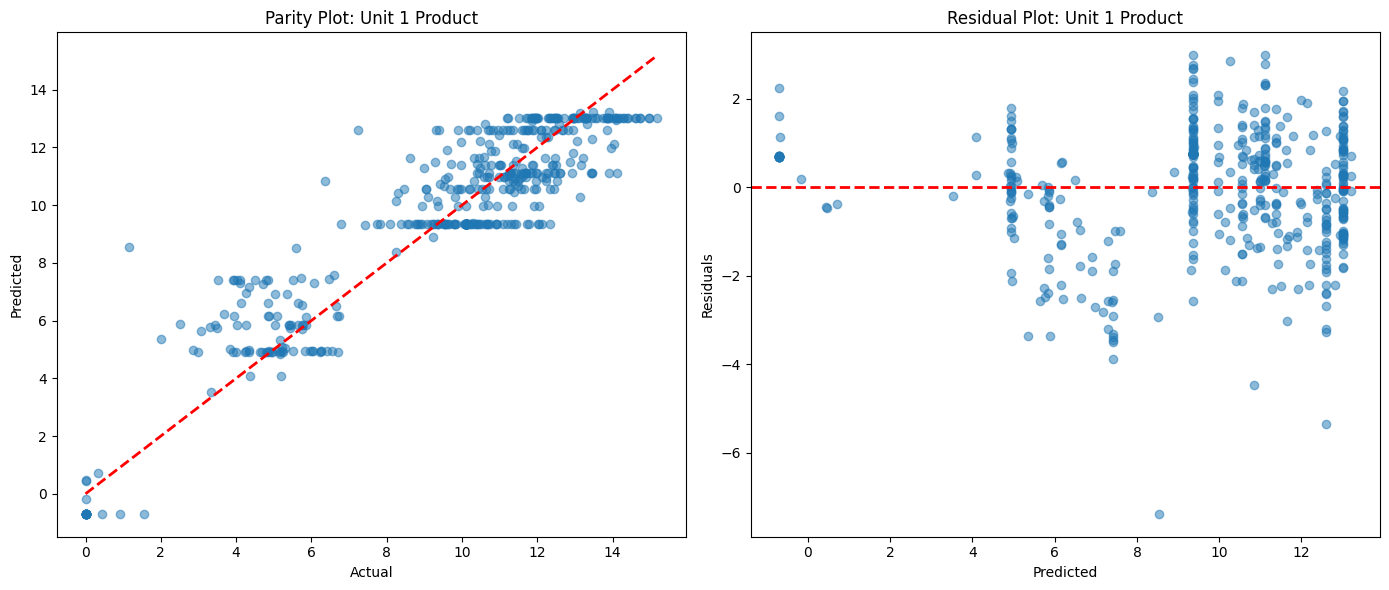

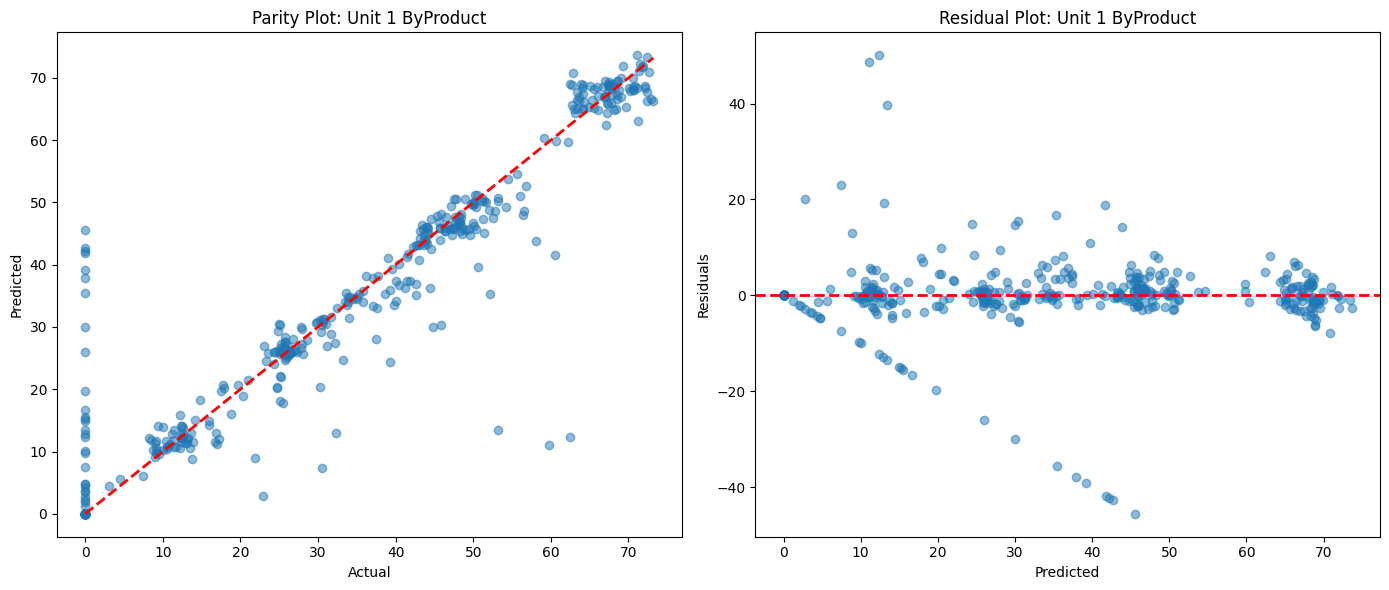

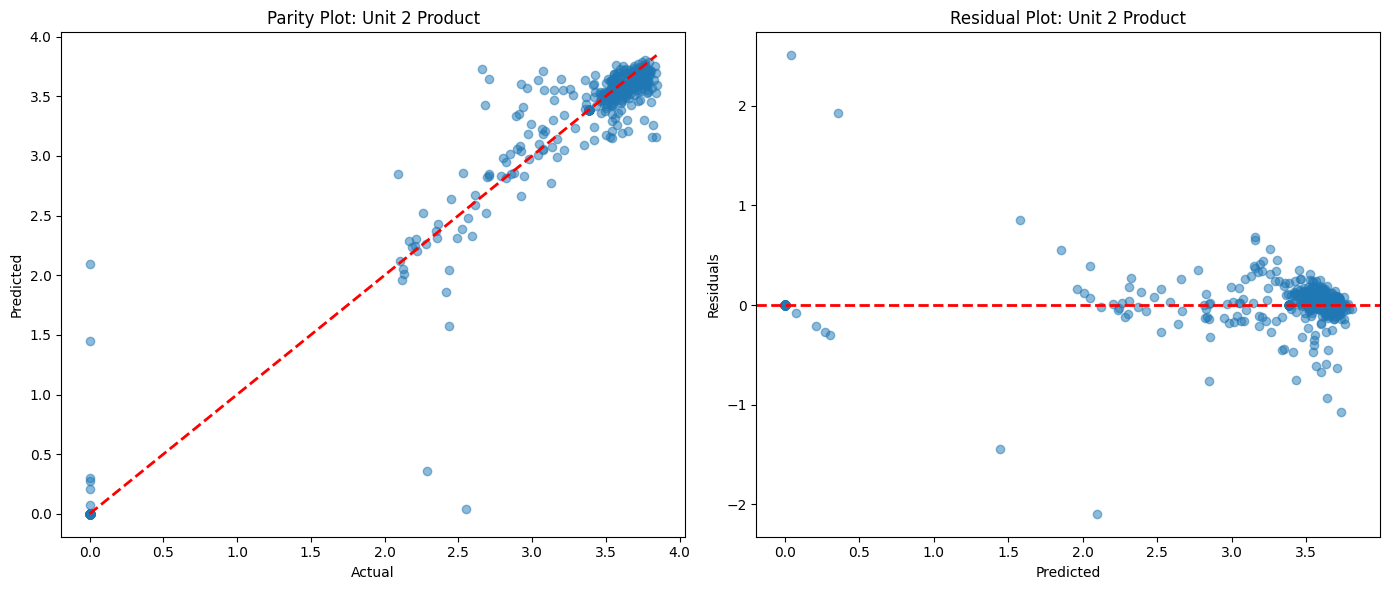

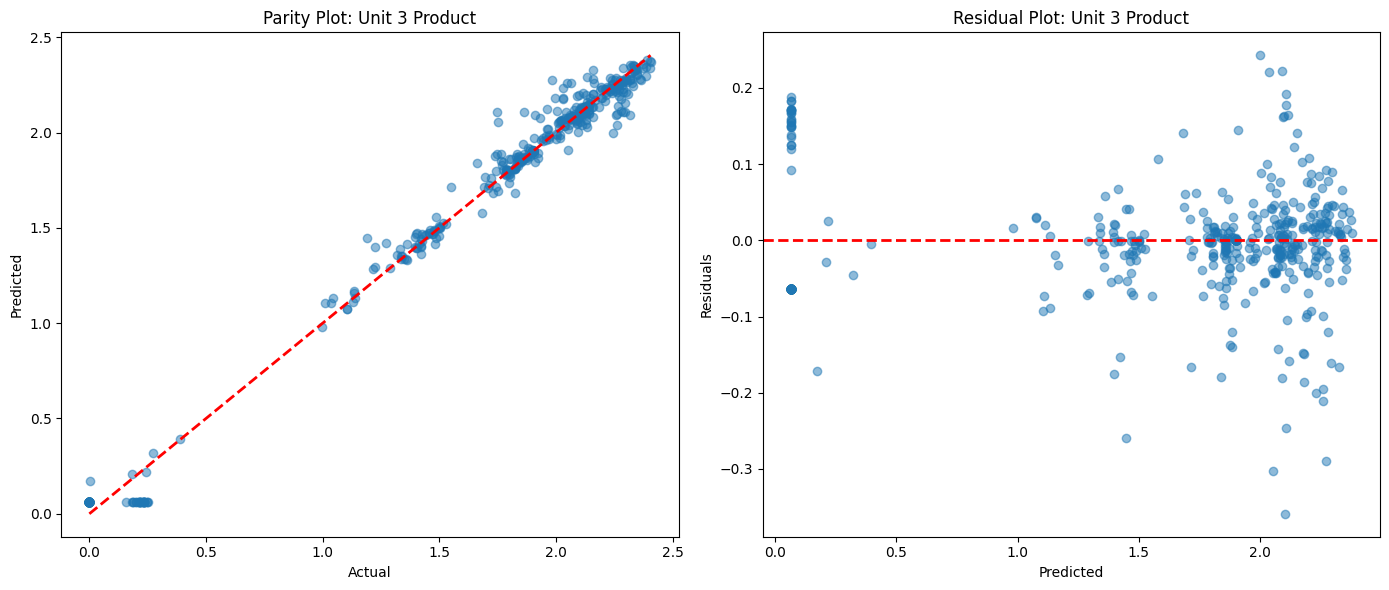

In [64]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Revised `modelperf` function to handle very small values in `y_test`
def modelperf(y_pred, y_test, min_denominator=1e-3):
    mask = np.abs(y_test) > min_denominator  # Ignore small `y_test` values for MAPE
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    if mask.sum() > 0:
        mape = np.mean(np.abs((y_test[mask] - y_pred[mask]) / y_test[mask])) * 100
    else:
        mape = np.nan  # Assign NaN if no valid `y_test` values are above the threshold
    rmse = np.sqrt(mse)
    return {"MSE": mse, "MAE": mae, "R2": r2, "MAPE": mape, "RMSE": rmse}

# Generate predictions for each model using the correct test sets
y_pred_1_product = model1_product.predict(unit_1_test_poly_df)  # Use polynomial features
y_pred_1_byproduct = model1_byproduct.predict(unit_1_test[["Raw1", "Product1"]])  # Use original Raw1 for ByProduct model
y_pred_2_product = model2_product.predict(unit_2_test[["ByProduct_From_1_to_2", "Raw2"]])
y_pred_3_product = model3_product.predict(unit_3_test[["ByProduct_From_1_to_3", "Raw3_1", "Raw3_2"]])

# Convert true values to 1D arrays for evaluation
y_test_1_product = unit_1_test["Product1"].values.ravel()
y_test_1_byproduct = unit_1_test["ByProduct"].values.ravel()
y_test_2_product = unit_2_test["Product2"].values.ravel()
y_test_3_product = unit_3_test["Product3"].values.ravel()

# Calculate metrics for each model
unit1_product_metrics = modelperf(y_pred_1_product, y_test_1_product)
unit1_byproduct_metrics = modelperf(y_pred_1_byproduct, y_test_1_byproduct)
unit2_product_metrics = modelperf(y_pred_2_product, y_test_2_product)
unit3_product_metrics = modelperf(y_pred_3_product, y_test_3_product)

# Print metrics for each model
print("Unit 1 Product Metrics:", unit1_product_metrics)
print("Unit 1 ByProduct Metrics:", unit1_byproduct_metrics)
print("Unit 2 Product Metrics:", unit2_product_metrics)
print("Unit 3 Product Metrics:", unit3_product_metrics)

# Define function to create parity and residual plots
def plot_evaluation(y_test, y_pred, title):
    # Ensure both are 1D and the same length
    y_test = np.ravel(y_test)
    y_pred = np.ravel(y_pred)
    if len(y_test) != len(y_pred):
        print(f"Error: Size mismatch in {title} - Test size: {len(y_test)}, Pred size: {len(y_pred)}")
        return

    plt.figure(figsize=(14, 6))
    
    # Parity Plot
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"Parity Plot: {title}")

    # Residual Plot
    plt.subplot(1, 2, 2)
    residuals = y_test - y_pred
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(0, color='r', linestyle='--', lw=2)
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.title(f"Residual Plot: {title}")
    
    plt.tight_layout()
    plt.show()

# Generate parity and residual plots for each model
plot_evaluation(y_test_1_product, y_pred_1_product, "Unit 1 Product")
plot_evaluation(y_test_1_byproduct, y_pred_1_byproduct, "Unit 1 ByProduct")
plot_evaluation(y_test_2_product, y_pred_2_product, "Unit 2 Product")
plot_evaluation(y_test_3_product, y_pred_3_product, "Unit 3 Product")


Now we can build a final version of the model that is built with all the data

In [65]:
import os
import pickle
import joblib
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd
from sklearn.model_selection import train_test_split

# Ensure the model directory exists
model_directory = "unit_models"
os.makedirs(model_directory, exist_ok=True)

# Define train_model function to support saving the final trained models
def train_model(df, input_vars, output_vars, model_name, model_type="Linear", save_model=False):   
    cleanX = df[input_vars] 
    cleany = df[output_vars].values.ravel()

    if model_type == "Linear":
        model = LinearRegression()
    elif model_type == "RandomForest":
        model = RandomForestRegressor(n_estimators=100, random_state=20)
    
    model.fit(cleanX, cleany)

    # Save the model if requested
    if save_model:
        with open(f"{model_directory}/{model_name}.pkl", 'wb') as f:
            pickle.dump(model, f)
        joblib.dump(model, f"{model_directory}/{model_name}.joblib")
    
    return model

# Final Model Training with Complete Data
# Combining all available data for each unit to build the final models
clean_unit1, clean_unit2, clean_unit3 = [pd.concat([train, test]) for train, test in [
    train_test_split(unit, test_size=0.3) for unit in [unit_1, unit_2, unit_3]
]]

# Step 1: Generate polynomial features for Unit 1's Raw1 and merge with target 'Product1' in the final dataset
poly_transformer = PolynomialFeatures(degree=2, include_bias=False)
unit_1_poly = poly_transformer.fit_transform(clean_unit1[["Raw1"]])
unit_1_poly_df = pd.DataFrame(unit_1_poly, columns=poly_transformer.get_feature_names_out(["Raw1"]), index=clean_unit1.index)

# Merging the polynomial features with the target variable 'Product1'
unit_1_poly_df["Product1"] = clean_unit1["Product1"].values  # Keep Product1 as target

# Step 2: Train and save the final models for each unit
# Final model for Unit 1 Product1 using Linear Regression on "Raw1" with polynomial features
model1_product_final = train_model(unit_1_poly_df, poly_transformer.get_feature_names_out(["Raw1"]), ["Product1"], "product_1_final", model_type="Linear", save_model=True)

# Train final model for Unit 1 ByProduct using Raw1 without transformation
model1_byproduct_final = train_model(clean_unit1, ["Raw1"], ["ByProduct"], "byproduct_final", model_type="RandomForest", save_model=True)

# Train final models for Unit 2 and Unit 3 products
model2_product_final = train_model(clean_unit2, ["ByProduct_From_1_to_2", "Raw2"], ["Product2"], "product_2_final", model_type="RandomForest", save_model=True)
model3_product_final = train_model(clean_unit3, ["ByProduct_From_1_to_3", "Raw3_1", "Raw3_2"], ["Product3"], "product_3_final", model_type="RandomForest", save_model=True)

print("Final models trained and saved for deployment.")


Final models trained and saved for deployment.


# Plant Model Build

The next step in the process is to build a model for the whole of the plant. This will take as inputs, the feed rates of the 4 raw feeds, as well as the fraction of byproduct that is directed to each of unit2 and unit3. 

In [66]:
import joblib
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures

# Assume poly_transformer was already fit on "Raw1"
poly_transformer = PolynomialFeatures(degree=2, include_bias=False)
poly_transformer.fit(unit_1_train[["Raw1"]])  # Fit on Raw1 during training

def plant(plant_input: pd.DataFrame):
    """
    Plant function to predict Product1, ByProduct, Product2, and Product3.
    Allocates byproduct between Unit 2 and Unit 3, with an excess stream if applicable.
    """

    # Normalize byproduct allocation fractions for unit 2 and unit 3
    allocation_total = plant_input["byproduct_to_unit2"] + plant_input["byproduct_to_unit3"]
    plant_input["byproduct_to_unit2"] /= allocation_total
    plant_input["byproduct_to_unit3"] /= allocation_total

    # Load trained models
    reg_product1 = joblib.load("unit_models/product_1_final.joblib")
    reg_byproduct = joblib.load("unit_models/byproduct_final.joblib")
    reg_product2 = joblib.load("unit_models/product_2_final.joblib")
    reg_product3 = joblib.load("unit_models/product_3_final.joblib")

    # Step 1: Predict Product1 using polynomial-transformed "Raw1"
    plant_input_poly = poly_transformer.transform(plant_input[["Raw1"]])
    product1 = reg_product1.predict(pd.DataFrame(plant_input_poly, columns=poly_transformer.get_feature_names_out(["Raw1"]))).flatten()
    plant_input["Product1"] = product1  # Add Product1 directly to plant_input

    # Step 2: Predict ByProduct using "Raw1" and "Product1" as inputs
    # Directly pass plant_input with both "Raw1" and "Product1" columns for prediction
    byproduct_input = plant_input[["Raw1"]]  # Include Product1 prediction
    byproduct = reg_byproduct.predict(byproduct_input).flatten()
    plant_input["byproduct"] = byproduct

    # Step 3: Allocate ByProduct to Unit 2 and Unit 3 based on input proportions
    plant_input["ByProduct_From_1_to_2"] = byproduct * plant_input["byproduct_to_unit2"]
    plant_input["ByProduct_From_1_to_3"] = byproduct * plant_input["byproduct_to_unit3"]

    # Step 4: Predict Product2 and Product3 using their respective models and ByProduct allocations
    product2 = reg_product2.predict(plant_input[["ByProduct_From_1_to_2", "Raw2"]]).flatten()
    product3 = reg_product3.predict(plant_input[["ByProduct_From_1_to_3", "Raw3_1", "Raw3_2"]]).flatten()

    # Calculate any excess byproduct
    byproduct_allocated = plant_input["ByProduct_From_1_to_2"] + plant_input["ByProduct_From_1_to_3"]
    excess_byproduct = byproduct - byproduct_allocated

    # Handle minor discrepancies in excess byproduct
    tolerance = 1e-5  # Define a tolerance level for floating-point discrepancies
    excess_byproduct = excess_byproduct.apply(lambda x: x if abs(x) > tolerance else 0)

    return product1, product2, product3, excess_byproduct

# Example input for validation
test_input = pd.DataFrame({
    "Raw1": [100],
    "Raw2": [50],
    "Raw3_1": [30],
    "Raw3_2": [20],
    "byproduct_to_unit2": [0.6],
    "byproduct_to_unit3": [0.4],
})

# Run the plant function and display results
product1, product2, product3, byproduct_splits = plant(test_input)
print("Product1:", product1)
print("Product2:", product2)
print("Product3:", product3)
print("Excess Byproduct:", byproduct_splits)


Product1: [7.78606876]
Product2: [3.63427794]
Product3: [2.18147559]
Excess Byproduct: 0    0
dtype: int64


# Plant Optimization

Now we need to define the objective function to use for the optimization

In [67]:
def objective_function(product1, product2, product3, byproduct,
                       product_sell_prices, product_demand, unmet_demand_penalty,
                       storage_costs, discard_costs, detailed=False):
    
    # Ensure all product inputs are Series
    product1, product2, product3, byproduct = map(pd.Series, (product1, product2, product3, byproduct))

    # Revenue from each product
    revenue1 = product1 * product_sell_prices["Product1"]
    revenue2 = product2 * product_sell_prices["Product2"]
    revenue3 = product3 * product_sell_prices["Product3"]
    
    # Over-production storage cost if production exceeds demand
    over_production_cost1 = storage_costs["Product1"] * (product1 - product_demand["Product1"]).clip(lower=0)
    over_production_cost2 = storage_costs["Product2"] * (product2 - product_demand["Product2"]).clip(lower=0)
    over_production_cost3 = storage_costs["Product3"] * (product3 - product_demand["Product3"]).clip(lower=0)
    
    # Under-production penalty if production falls short of demand
    under_production_cost1 = unmet_demand_penalty["Product1"] * (product_demand["Product1"] - product1).clip(lower=0)
    under_production_cost2 = unmet_demand_penalty["Product2"] * (product_demand["Product2"] - product2).clip(lower=0)
    under_production_cost3 = unmet_demand_penalty["Product3"] * (product_demand["Product3"] - product3).clip(lower=0)
    
    # Discard cost for excess byproduct
    excess_byproduct_cost = byproduct.clip(lower=0) * discard_costs["byproduct"]

    # Total objective function calculation
    total_revenue = revenue1 + revenue2 + revenue3
    total_cost = (over_production_cost1 + over_production_cost2 + over_production_cost3 +
                  under_production_cost1 + under_production_cost2 + under_production_cost3 +
                  excess_byproduct_cost)

    objective_value = total_revenue - total_cost

    if detailed:
        return (objective_value, revenue1, over_production_cost1, under_production_cost1,
                revenue2, over_production_cost2, under_production_cost2,
                revenue3, over_production_cost3, under_production_cost3, excess_byproduct_cost)
    else:
        return objective_value


Now we need to build the optimizer. Based on prior experience, the differential evolution algorithm has been selected for the optimizer, however, this is not required

In [68]:
def optimizer(
        bounds, 
        opt_params, 
        PRODUCT_SELL_PRICE, 
        PRODUCT_DEMAND, 
        PRODUCT_UNMET_DEMAND_PENALTY,
        PRODUCT_STORAGE_COST, 
        PRODUCT_DISCARD_COST
        ):
    
    def model(X_in):
        if len(X_in.shape) == 1:
            X_in = X_in.reshape([1,6])
        X_in = pd.DataFrame(X_in, columns=["Raw1","Raw2","Raw3_1","Raw3_2","byproduct_to_unit2","byproduct_to_unit3"])
        if np.isnan(X_in.iloc[0,0]):
            return np.nan
        product1, product2, product3, byproduct = plant(X_in)

        objective = objective_function(product1, product2, product3, byproduct,
                       PRODUCT_SELL_PRICE, PRODUCT_DEMAND, PRODUCT_UNMET_DEMAND_PENALTY,
                       PRODUCT_STORAGE_COST, PRODUCT_DISCARD_COST)
        return objective.iloc[0]

    result = differential_evolution(model, bounds=bounds, **opt_params)

    return result

# Final Output

We need to capture the outputs from all the scenarios

In [69]:
import yaml
from scipy.optimize import differential_evolution

# Load parameters from the YAML file
with open("parameters.yaml", "r") as file:
    params = yaml.safe_load(file)

# Extracting BOUNDS and OPT_PARAMS from the loaded parameters
BOUNDS = params["bounds"]
OPT_PARAMS = {
    "popsize": params["opt_params"]["popsize"],
    "maxiter": params["opt_params"]["maxiter"],
    "mutation": tuple(params["opt_params"]["mutation"]),
    "recombination": params["opt_params"]["recombination"],
    "strategy": params["opt_params"]["strategy"],
    "seed": params["opt_params"]["seed"]
}

# Now BOUNDS and OPT_PARAMS are set up as needed for the optimizer


"""
############################################
Scenario extraction
"""

def get_scenario_dict():
    all_scenarios = {}

    df = pd.read_excel("scenarios.xlsx", index_col=0, header=[0,1])

    for ii in range(df.shape[0]):
        for jj in range(5):
            all_scenarios[df.index[ii]] = {
                "PRODUCT_SELL_PRICE": {
                    "Product1": df.iloc[ii,0], 
                    "Product2": df.iloc[ii,1], 
                    "Product3": df.iloc[ii,2]
                    },
                "PRODUCT_DEMAND": {
                    "Product1": df.iloc[ii,3], 
                    "Product2": df.iloc[ii,4], 
                    "Product3": df.iloc[ii,5]
                    },
                "PRODUCT_UNMET_DEMAND_PENALTY": {
                    "Product1": df.iloc[ii,14], 
                    "Product2": df.iloc[ii,15], 
                    "Product3": df.iloc[ii,16]
                    },
                "PRODUCT_STORAGE_COST": {
                    "Product1": df.iloc[ii,6], 
                    "Product2": df.iloc[ii,7], 
                    "Product3": df.iloc[ii,8], 
                    "byproduct": df.iloc[ii,9]
                    },
                "PRODUCT_DISCARD_COST": {
                    "Product1": df.iloc[ii,10], 
                    "Product2": df.iloc[ii,11], 
                    "Product3": df.iloc[ii,12], 
                    "byproduct": df.iloc[ii,13]
                    }
                }

    return all_scenarios

# Define a function to handle scenario updates dynamically
def update_scenario(
        scenario_key,
        scenario_dict
    ):

    return {
        'PRODUCT_SELL_PRICE': scenario_dict[scenario_key]['PRODUCT_SELL_PRICE'],
        'PRODUCT_DEMAND': scenario_dict[scenario_key]['PRODUCT_DEMAND'],
        'PRODUCT_UNMET_DEMAND_PENALTY': scenario_dict[scenario_key]['PRODUCT_UNMET_DEMAND_PENALTY'],
        'PRODUCT_STORAGE_COST': scenario_dict[scenario_key]['PRODUCT_STORAGE_COST'],
        'PRODUCT_DISCARD_COST': scenario_dict[scenario_key]['PRODUCT_DISCARD_COST']
    }

# Now define which scenarios to run
scenarios_to_run = ['scenario1', 'scenario2', 'scenario3', 'scenario4' ]
scenario_dict = get_scenario_dict()

# Iterate and run the scenarios
for scenario in scenarios_to_run:
    print(f"Running {scenario}...")
    scenario_data = update_scenario(scenario, scenario_dict)
    
    print(f"PRODUCT_DEMAND: {scenario_data['PRODUCT_DEMAND']}")
    print(f"PRODUCT_SELL_PRICE: {scenario_data['PRODUCT_SELL_PRICE']}")
    print(f"PRODUCT_STORAGE_COST: {scenario_data['PRODUCT_STORAGE_COST']}")
    print(f"PRODUCT_DISCARD_COST: {scenario_data['PRODUCT_DISCARD_COST']}")
    print(f"PRODUCT_UNMET_DEMAND_PENALTY: {scenario_data['PRODUCT_UNMET_DEMAND_PENALTY']}")
    print("-------------------")

"""
############################################
Running the optimizer
"""
scenario_dict = get_scenario_dict()

scenario_results = {}
# Run the optimizer for each of these scenarios
for scenario in scenario_dict.keys():
    print(f"Running {scenario}...")
    scenario_data = update_scenario(scenario, scenario_dict)

    PRODUCT_SELL_PRICE = scenario_data.get('PRODUCT_SELL_PRICE', {})
    PRODUCT_DEMAND = scenario_data.get('PRODUCT_DEMAND', {})
    PRODUCT_UNMET_DEMAND_PENALTY = scenario_data.get('PRODUCT_UNMET_DEMAND_PENALTY', {})
    PRODUCT_STORAGE_COST = scenario_data.get('PRODUCT_STORAGE_COST', {})
    PRODUCT_DISCARD_COST = scenario_data.get('PRODUCT_DISCARD_COST', {})

    result = optimizer(BOUNDS, OPT_PARAMS, PRODUCT_SELL_PRICE, PRODUCT_DEMAND,PRODUCT_UNMET_DEMAND_PENALTY,PRODUCT_STORAGE_COST, PRODUCT_DISCARD_COST)

    scenario_results[scenario] = {
        "fun": -result.fun,  
        "x": result.x,      
        
    }

    print(f"Result for {scenario}: {-result.fun}")

"""
############################################
Output Results
"""

def model_for_output(
        X_in, 
        scenario, 
        PRODUCT_SELL_PRICE, 
        PRODUCT_DEMAND, 
        PRODUCT_UNMET_DEMAND_PENALTY,
        PRODUCT_STORAGE_COST, 
        PRODUCT_DISCARD_COST
    ):
    if len(X_in.shape) == 1:
        X_in = X_in.reshape([1,6])
    X_in = pd.DataFrame(X_in, columns=["Raw1","Raw2","Raw3_1","Raw3_2","byproduct_to_unit2","byproduct_to_unit3"])
    if np.isnan(X_in.iloc[0,0]):
        return np.nan
    product1, product2, product3, byproduct = plant(X_in)

    print(product1, product2, product3, byproduct)
    (objective, Product1_revenue, Product1_over_production_cost, Product1_under_production_cost, 
     Product2_revenue, Product2_over_production_cost, Product2_under_production_cost, Product3_revenue, 
     Product3_over_production_cost, Product3_under_production_cost, excess_byproduct_cost) = objective_function(product1, product2, product3, byproduct,
                    PRODUCT_SELL_PRICE, PRODUCT_DEMAND, PRODUCT_UNMET_DEMAND_PENALTY,
                    PRODUCT_STORAGE_COST, PRODUCT_DISCARD_COST, True)

    output_df_dict = {
        "Scenario": [scenario],
        "Raw1": [X_in.loc[0,"Raw1"]],
        "Raw2": [X_in.loc[0,"Raw2"]],
        "Raw3_1": [X_in.loc[0,"Raw3_1"]],
        "Raw3_2": [X_in.loc[0,"Raw3_2"]],
        "Weight_byproduct_to_unit2": [X_in.loc[0,"byproduct_to_unit2"]],
        "Weight_byproduct_to_unit3": [X_in.loc[0,"byproduct_to_unit3"]],
        "Product1_production": [product1[0]],
        "Product2_production": [product2[0]],
        "Product3_production": [product3[0]],
        "Byproduct_production": [byproduct[0]],
        "Total Revenue": [objective.iloc[0]],
        "Product1_Revenue": [Product1_revenue[0]],
        "Product1_Over_Production_cost": [Product1_over_production_cost[0]],
        "Product1_Under_Production_cost": [Product1_under_production_cost[0]],
        "Product2_Revenue": [Product2_revenue[0]],
        "Product2_Over_Production_cost": [Product2_over_production_cost[0]],
        "Product2_Under_Production_cost": [Product2_under_production_cost[0]],
        "Product3_Revenue": [Product3_revenue[0]],
        "Product3_Over_Production_cost": [Product3_over_production_cost[0]],
        "Product3_Under_Production_cost": [Product3_under_production_cost[0]],
        "Excess_byproduct_cost": [excess_byproduct_cost[0]],
    }
    return pd.DataFrame(output_df_dict)
# Saving the scenarios into CSV's
k=1

scenario_dict = get_scenario_dict()

for scenario in scenario_dict.keys():
    print(f"Running {scenario} with iteration {k}...")
    scenario_data = update_scenario(scenario, scenario_dict)
    result_x = scenario_results[scenario]["x"] 

    PRODUCT_SELL_PRICE = scenario_data.get('PRODUCT_SELL_PRICE', {})
    PRODUCT_DEMAND = scenario_data.get('PRODUCT_DEMAND', {})
    PRODUCT_UNMET_DEMAND_PENALTY = scenario_data.get('PRODUCT_UNMET_DEMAND_PENALTY', {})
    PRODUCT_STORAGE_COST = scenario_data.get('PRODUCT_STORAGE_COST', {})
    PRODUCT_DISCARD_COST = scenario_data.get('PRODUCT_DISCARD_COST', {})

    
    df = model_for_output(result_x, scenario, PRODUCT_SELL_PRICE, PRODUCT_DEMAND,PRODUCT_UNMET_DEMAND_PENALTY,PRODUCT_STORAGE_COST, PRODUCT_DISCARD_COST)
    df.to_csv(f"scenario_output_{k}.csv")
    k = k+1


"""
############################################
Some analysis
"""

#Change number of scenarios to run here
scenario_dict = get_scenario_dict()
scenarios_to_run = list(scenario_dict.keys())
csv_files = [f"scenario_output_{i}.csv" for i in range(1, len(scenarios_to_run) + 1)]

total_revenues = []
scenario_labels = []

for scenario, csv_file in zip(scenarios_to_run, csv_files):

    df = pd.read_csv(csv_file)
    total_revenue = df["Total Revenue"].iloc[0]  
    print(total_revenue)
    total_revenues.append(total_revenue)
    scenario_labels.append(scenario)

fig = go.Figure()

fig.add_trace(go.Bar(
    x=scenario_labels,  
    y=total_revenues,   
    name="Total Revenue",
    marker_color='lightblue'
))

fig.update_layout(
    title="Total Revenue Comparison Across Scenarios",
    xaxis_title="Scenario",
    yaxis_title="Total Revenue",
    barmode="group",
    template="plotly_white"
)

fig.show()

from tabulate import tabulate

total_revenues = []
scenario_labels = []
product1_production = []
product2_production = []
product3_production = []
raw1_values = []
raw2_values = []
raw3_1_values = []
raw3_2_values = []
byproduct_unit2 = []
byproduct_unit3 = []
for scenario, csv_file in zip(scenarios_to_run, csv_files):

    df = pd.read_csv(csv_file)
    total_revenue = df["Total Revenue"]

    product1 = df["Product1_production"].iloc[0]  
    product2 = df["Product2_production"].iloc[0]  
    product3 = df["Product3_production"].iloc[0]

    raw1 = df["Raw1"].iloc[0]
    raw2 = df["Raw2"].iloc[0]
    raw3_1 = df["Raw3_1"].iloc[0]
    raw3_2 = df["Raw3_2"].iloc[0]
    Weight_byproduct_to_unit2 = df["Weight_byproduct_to_unit2"].iloc[0]
    Weight_byproduct_to_unit3 = df["Weight_byproduct_to_unit3"].iloc[0]

    
    product1_production.append(product1)
    product2_production.append(product2)
    product3_production.append(product3)

    raw1_values.append(raw1)
    raw2_values.append(raw2)
    raw3_1_values.append(raw3_1)
    raw3_2_values.append(raw3_2)
    byproduct_unit2.append(Weight_byproduct_to_unit2)
    byproduct_unit3.append(Weight_byproduct_to_unit3)
    scenario_labels.append(scenario)

# Create a summary DataFrame to print the comparison
summary_df = pd.DataFrame({
    "Scenario": scenario_labels,
    "Raw1": raw1_values,
    "Raw2": raw2_values,
    "Raw3_1": raw3_1_values,
    "Raw3_2": raw3_2_values,
    "Product1_Production": product1_production,
    "Product2_Production": product2_production,
    "Product3_Production": product3_production,
    "Weight_byproduct_to_unit2": byproduct_unit2,
    "Weight_byproduct_to_unit3": byproduct_unit3,
    
})
headers = ["Scenario", "Product1_Production", "Product2_Production", "Product3_Production", 
           "Raw1", "Raw2", "Raw3_1", "Raw3_2", "Weight_byproduct_to_unit2", "Weight_byproduct_to_unit3"]

print("\nSummary of All Scenarios:\n")
print(tabulate(summary_df, headers, tablefmt="fancy_grid", numalign="center", stralign="center"))


# Create the bar chart
fig = go.Figure()

# Adding Product1 Production
fig.add_trace(go.Bar(
    x=scenario_labels,  
    y=product1_production,  
    name="Product1 Production",
    marker_color='lightblue'
))

fig.add_trace(go.Bar(
    x=scenario_labels,
    y=product2_production,
    name="Product2 Production",
    marker_color='lightgreen'
))

# Adding Product3 Production
fig.add_trace(go.Bar(
    x=scenario_labels,
    y=product3_production,
    name="Product3 Production",
    marker_color='palevioletred'
))

# Adding Raw1 as a Line Graph
fig.add_trace(go.Scatter(
    x=scenario_labels,
    y=raw1_values,
    name="Raw1",
    mode='lines+markers',
    line=dict(color='black', width=2),
    yaxis="y2"  # Use secondary y-axis
))

# Adding Raw2 as a Line Graph
fig.add_trace(go.Scatter(
    x=scenario_labels,
    y=raw2_values,
    name="Raw2",
    mode='lines+markers',
    line=dict(color='orange', width=2),
    yaxis="y2"  # Use secondary y-axis
))

# Adding Raw3_1 as a Line Graph
fig.add_trace(go.Scatter(
    x=scenario_labels,
    y=raw3_1_values,
    name="Raw3_1",
    mode='lines+markers',
    line=dict(color='purple', width=2),
    yaxis="y2"  
))

# Adding Raw3_2 as a Line Graph
fig.add_trace(go.Scatter(
    x=scenario_labels,
    y=raw3_2_values,
    name="Raw3_2",
    mode='lines+markers',
    line=dict(color='pink', width=2),
    yaxis="y2"  
))

# Update layout to include a secondary y-axis
fig.update_layout(
    title="Product Production and Raw Material Values Across Scenarios",
    xaxis_title="Scenarios",
    yaxis_title="Product Production",
    yaxis2=dict(
        title="Raw Values",
        overlaying="y",
        side="right"
    ),
    barmode="group"
)


fig.show()

Running scenario1...
PRODUCT_DEMAND: {'Product1': 10, 'Product2': 4, 'Product3': 2}
PRODUCT_SELL_PRICE: {'Product1': 800, 'Product2': 200, 'Product3': 400}
PRODUCT_STORAGE_COST: {'Product1': 12, 'Product2': 10, 'Product3': 4, 'byproduct': 50}
PRODUCT_DISCARD_COST: {'Product1': 10, 'Product2': 5, 'Product3': 2, 'byproduct': 30}
PRODUCT_UNMET_DEMAND_PENALTY: {'Product1': 0, 'Product2': 0, 'Product3': 0}
-------------------
Running scenario2...
PRODUCT_DEMAND: {'Product1': 12, 'Product2': 4, 'Product3': 2}
PRODUCT_SELL_PRICE: {'Product1': 900, 'Product2': 200, 'Product3': 400}
PRODUCT_STORAGE_COST: {'Product1': 12, 'Product2': 10, 'Product3': 4, 'byproduct': 50}
PRODUCT_DISCARD_COST: {'Product1': 10, 'Product2': 5, 'Product3': 2, 'byproduct': 30}
PRODUCT_UNMET_DEMAND_PENALTY: {'Product1': 0, 'Product2': 0, 'Product3': 0}
-------------------
Running scenario3...
PRODUCT_DEMAND: {'Product1': 14, 'Product2': 4, 'Product3': 2}
PRODUCT_SELL_PRICE: {'Product1': 1000, 'Product2': 200, 'Product3'

KeyboardInterrupt: 

# Visualisaction and Analysis

Let us get some visualisations of the outputs, or else get pretty printed versions that compare the outputs of the different scenarios